# Notebook for analyzing errors

In [1]:
import cv2
import numpy as np

import json


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_val.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/coco_pred_on_mpii/pred_better.json', 'r') as f:
    annot_pred_coco = json.load(f)

with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
    annot_pred_mpii = json.load(f)
with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/resnet_pred.json', 'r') as f:
    annot_better_pred_mpii = json.load(f)


In [2]:
len_truth = len(annot_truth)
print(len_truth)

2958


In [3]:
def distance(p1, p2, metrics='euclidian'):
  # euclidian distance
  # remove when ground truth is empty
  # p1_filtered = p1[ p1[:,0] != -1 ]
  # p2_filtered = p2[ p1[:,0] != -1 ]
  if metrics=='euclidian':
    return np.linalg.norm(np.array(p1) - np.array(p2), axis=1)


In [4]:
# MPII -> COCO map
mapping_names = ['right_ankle', 'right_knee', 'left_ankle', 'left_knee', 'right_hip', 'left_hip', 'left_wrist',
                 'left_elbow', 'left_shoulder', 'right_wrist', 'right_elbow', 'right_shoulder']
mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}

kps_truth_joint_vis = list()
kps_truth = list()
box_scale = list()
kps_pred = list()
kps_ids = list()
for i in range(len(annot_truth)):
  
  kp_truth = annot_truth[i]['joints']
  kp_pred = annot_pred_coco['annotations'][i]['joints']

  # do left ankle
  kps_truth_joint_vis.append(annot_truth[i]['joints_vis'])
  kps_truth.append(kp_truth)
  kps_pred.append(kp_pred)
  kps_ids.append((i, annot_truth[i]['image']))
  box_scale.append(annot_truth[i]['scale'])
kps_truth = np.array(kps_truth)
kps_pred = np.array(kps_pred)
box_scale = np.array(box_scale)
kps_truth_joint_vis = np.array(kps_truth_joint_vis)


print("kps_truth: ", kps_truth.shape)
print("kps_pred: ", kps_pred.shape)
print("box_scale:", box_scale.shape)
  

kps_truth:  (2958, 16, 2)
kps_pred:  (2958, 17, 2)
box_scale: (2958,)


In [5]:
import matplotlib.pyplot as plt

Testing

In [6]:
errors = distance(kps_truth[:, 0], kps_pred[:, mapping[0]])
print(errors[:10])
def calculate_error(p1,p2):
  euc_distance = distance(p1, p2)
  print(euc_distance.shape)

[  17.73007828    1.67128587 1255.20711129 1046.74382238    3.28500425
    6.56993827   17.31153519    2.3408224     5.61504124    1.95380624]


In [7]:

errors = []
# TODO: resolve joint missing
for key in mapping.keys():
    gts = kps_truth[:, key]
    predictions = kps_pred[:, mapping[key]]
    gts = gts[ kps_truth_joint_vis[:, key] == 1 ]
    predictions = predictions [ kps_truth_joint_vis[:, key] == 1 ]
    
    error = distance(gts, predictions) / box_scale[kps_truth_joint_vis[:, key] == 1 ]
    errors.append(error)
coco_pred_on_mpii_errors = errors


## Euclidian distance MPII Annot vs COCO Prediction

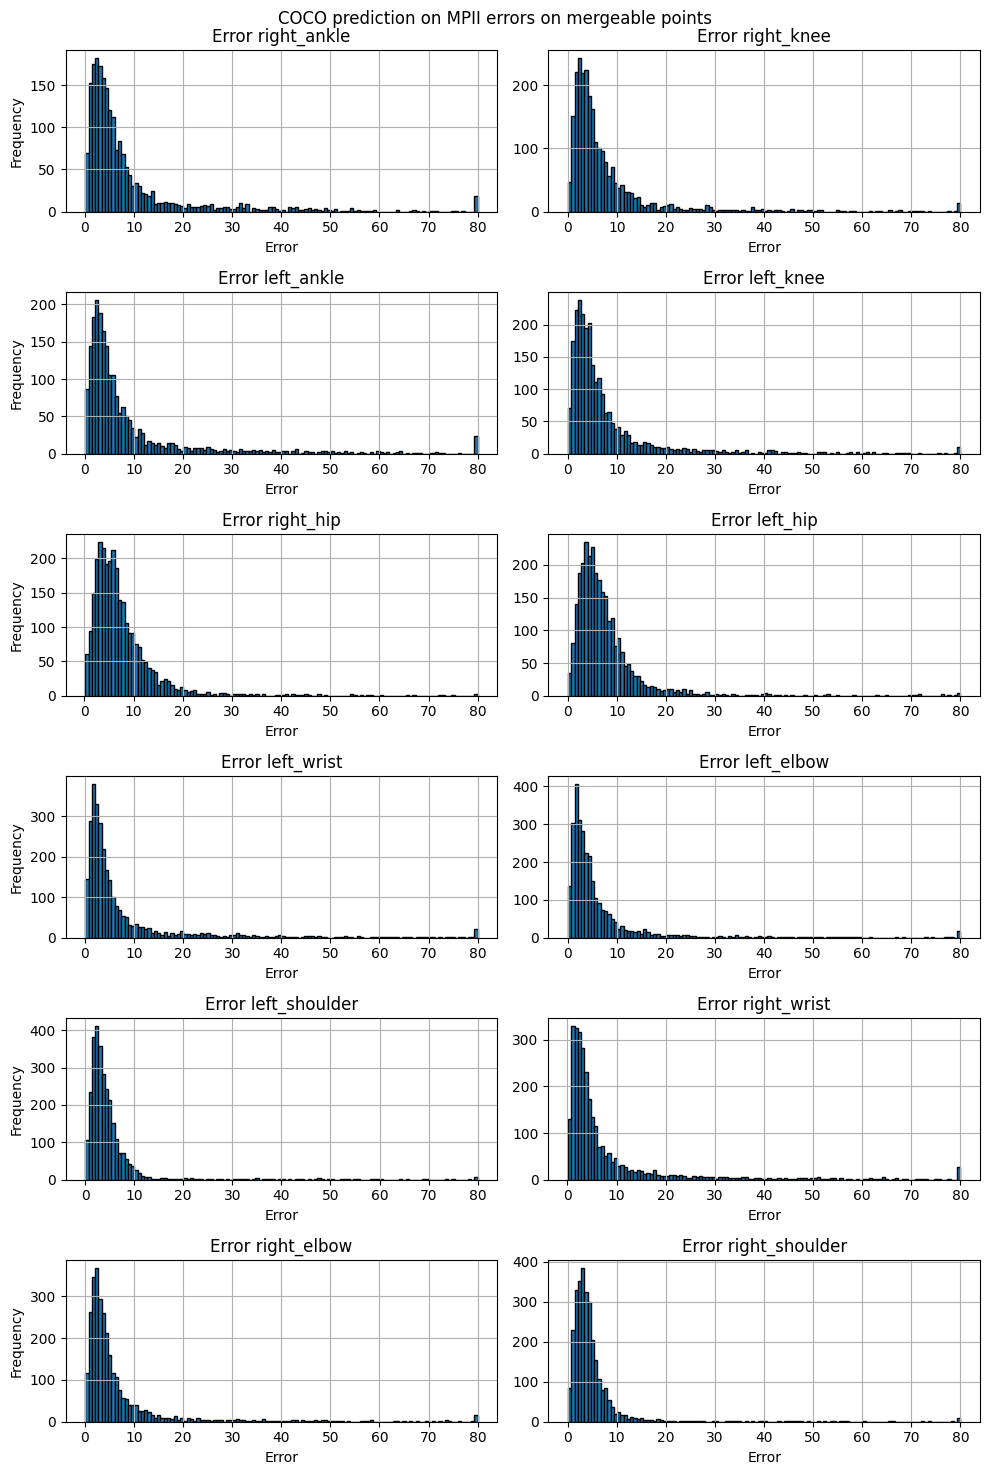

In [8]:
# left leg error

# Generate some example errors (replace this with your actual errors)
# errors = np.clip(0,100)
# Plot the histogram of errors
fig, axs = plt.subplots(nrows=(len(errors)+1)//2, ncols=2, figsize=(10,15))
fig.suptitle('COCO prediction on MPII errors on mergeable points')
for i in range(len(errors)):
  row = i // 2
  col = i % 2
  axs[row,col].hist(np.clip(errors[i], 0, 80), bins=120, edgecolor='black')
  axs[row,col].set_title(f'Error {mapping_names[i]}')
  axs[row,col].set_xlabel('Error')
  axs[row,0].set_ylabel('Frequency')
  axs[row,col].grid(True)
plt.tight_layout()
plt.show()

# TODO: normalize depending on image by the bounding box

### Check if there's any pattern in terms of y2-y1 x2-x1

In [9]:
kps_truth[:, key, 0].shape

(2958,)

In [10]:
errors = list()
for key in mapping.keys():
  gts = kps_truth[:, key]
  predictions = kps_pred[:, mapping[key]]
  gts = gts[ kps_truth_joint_vis[:, key] == 1 ]
  # if right ankle, subtract to make bell curve on 0
  predictions = predictions [ kps_truth_joint_vis[:, key] == 1 ]
  errors.append(
    np.stack(
      ((gts[:, 0] - predictions[:, 0]) / box_scale [ kps_truth_joint_vis[:, key] == 1 ], 
       (gts[:, 1] - predictions[:, 1]) / box_scale [ kps_truth_joint_vis[:, key] == 1 ]), axis=0)
    )
  if key == 0:
    offset_x = -0.5
    offset_y = -1.9
    print("error right ankle before sub")
    print('x: ', (np.abs(gts[:, 0] - predictions[:, 0]) / box_scale [ kps_truth_joint_vis[:, key] == 1 ]).sum() / len(gts[:,0]))
    print('y: ', (np.abs(gts[:, 1] - predictions[:, 1]) / box_scale [ kps_truth_joint_vis[:, key] == 1 ]).sum() / len(gts[:,1]))
    print("error right ankle after sub")
    print('x: ', (np.abs(gts[:, 0] - (predictions[:, 0] + offset_x)) / box_scale [ kps_truth_joint_vis[:, key] == 1 ]).sum() / len(gts[:,0]))
    print('y: ', (np.abs(gts[:, 1] - (predictions[:, 1] + offset_y)) / box_scale [ kps_truth_joint_vis[:, key] == 1 ]).sum() / len(gts[:,1]))
print(errors[0].shape)

error right ankle before sub
x:  5.713195991663048
y:  6.357997027000577
error right ankle after sub
x:  5.671822674575829
y:  6.140136816725341
(2, 2115)


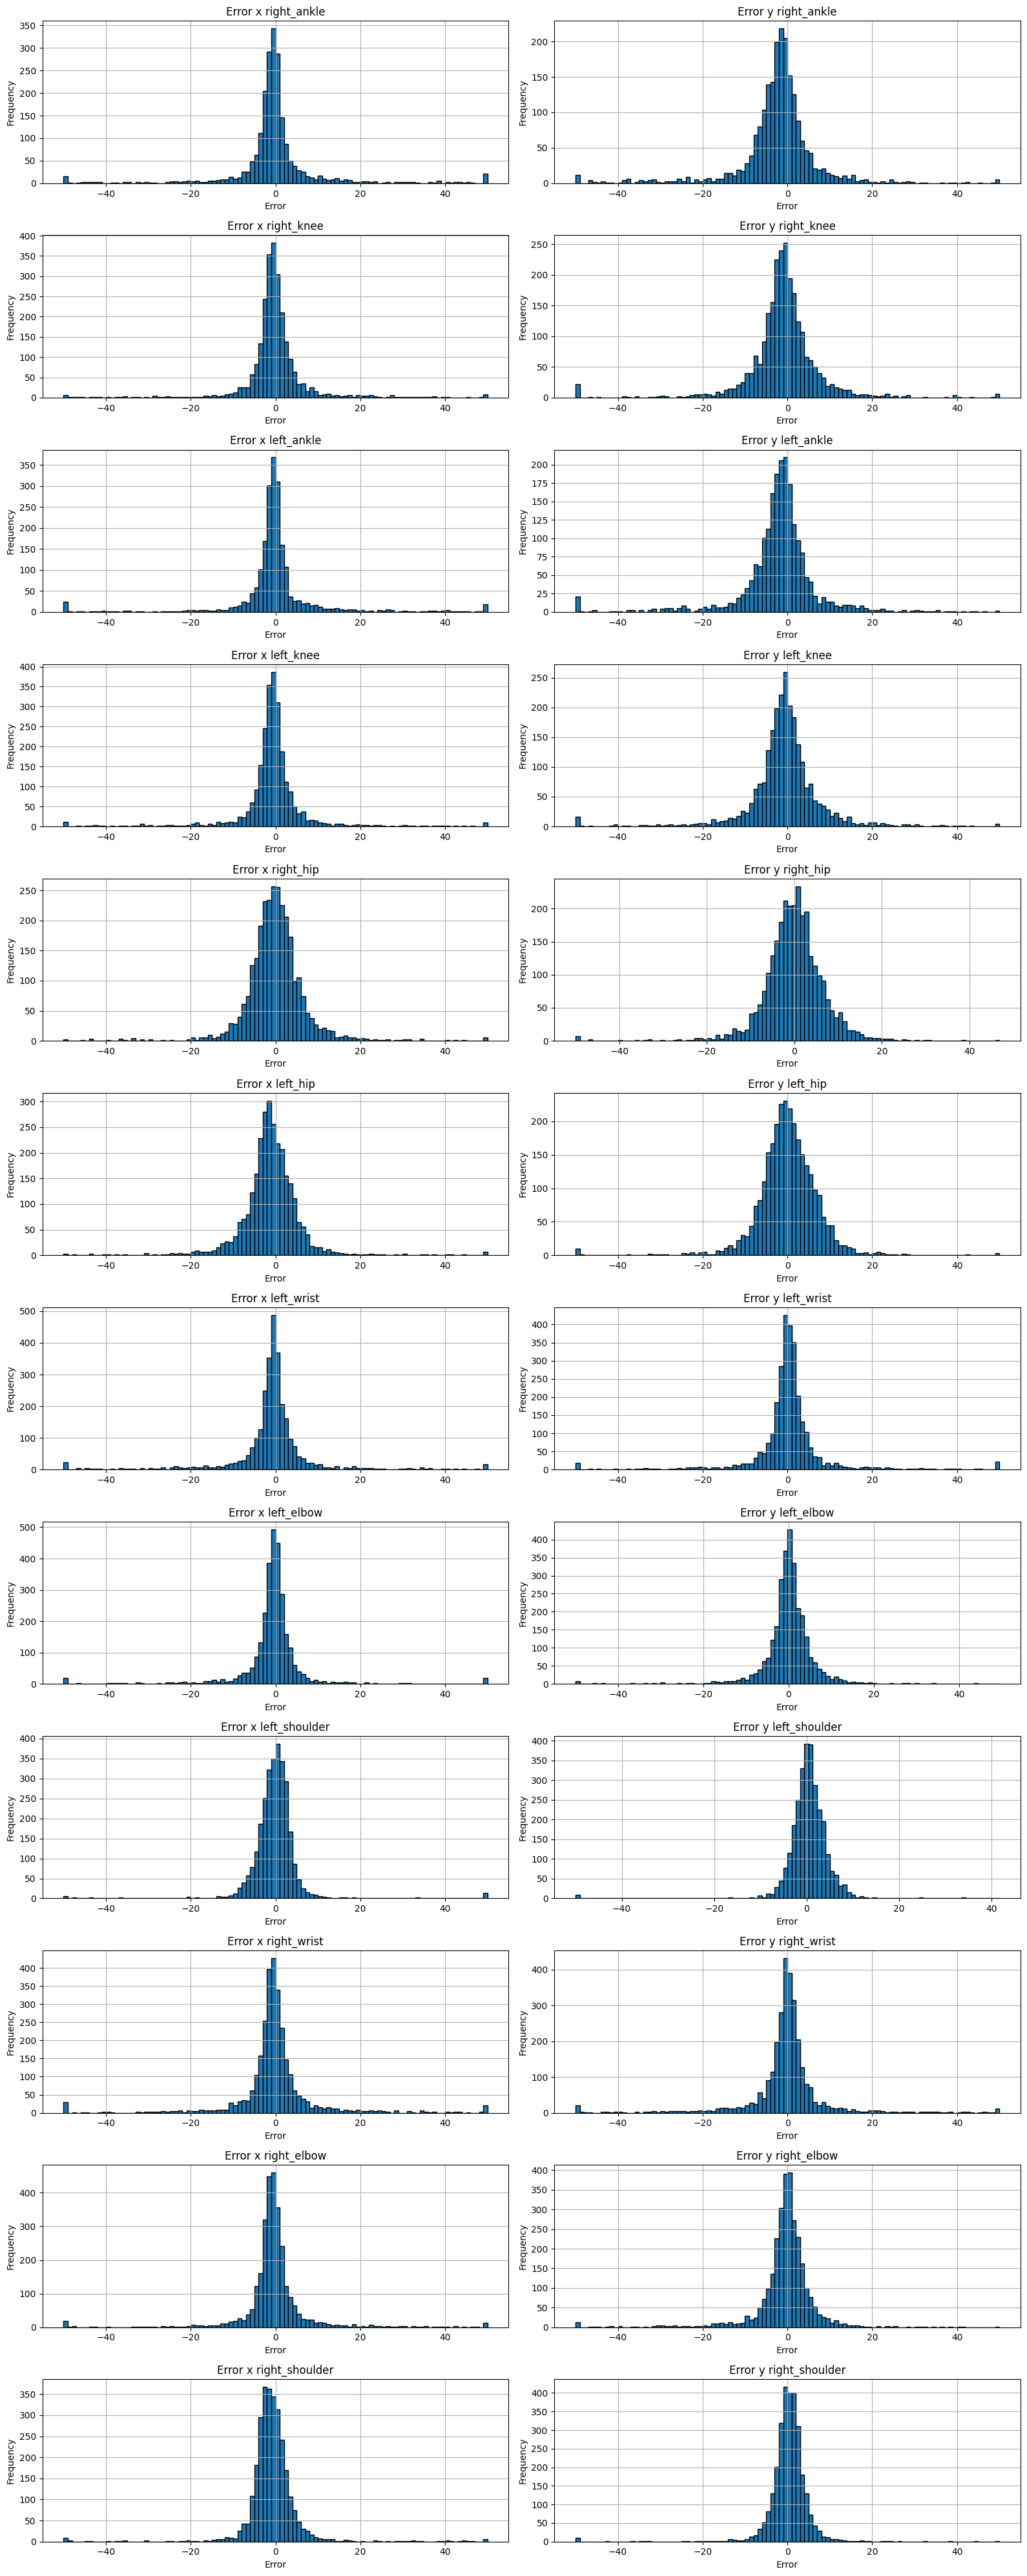

In [11]:

fig, axs = plt.subplots(nrows=(len(errors)), ncols=2, figsize=(16,40))
for i in range(len(errors)):
  row = i
  axs[row,0].hist(np.clip(errors[i][0], -50, 50), bins=100, edgecolor='black')
  axs[row,0].set_title(f'Error x {mapping_names[i]}')
  axs[row,0].set_xlabel('Error')
  axs[row,0].set_ylabel('Frequency')
  axs[row,0].grid(True)

  axs[row,1].hist(np.clip(errors[i][1], -50, 50), bins=100, edgecolor='black')
  axs[row,1].set_title(f'Error y {mapping_names[i]}')
  axs[row,1].set_xlabel('Error')
  axs[row,1].set_ylabel('Frequency')
  axs[row,1].grid(True)
plt.tight_layout()
plt.show()

## Evaluate with OKS(Object Keypoints Similarity) for AP

$$ OKS = \Sigma_{i} [exp(\frac{-d_{i}^{2}}{2s^{2}k_{i}^2}) \delta(v_{i}>0)] / \Sigma_{i} [\delta(v_{i}>0)]  $$
- where $d_{i}$ is euclidian distance for $i^{th}$ point
- where $s$ is the object scale and $k_{i}$ is a per-keypont constant that controls falloff
- where $v_{i}$ is visibility flag for $i^{th}$ keypoint

## Check if pelvis is just the average left and right hip

In [12]:
keypoint_info={
        0:
        dict(
            name='right_ankle',
            id=0,
            color=[255, 128, 0],
            type='lower',
            swap='left_ankle'),
        1:
        dict(
            name='right_knee',
            id=1,
            color=[255, 128, 0],
            type='lower',
            swap='left_knee'),
        2:
        dict(
            name='right_hip',
            id=2,
            color=[255, 128, 0],
            type='lower',
            swap='left_hip'),
        3:
        dict(
            name='left_hip',
            id=3,
            color=[0, 255, 0],
            type='lower',
            swap='right_hip'),
        4:
        dict(
            name='left_knee',
            id=4,
            color=[0, 255, 0],
            type='lower',
            swap='right_knee'),
        5:
        dict(
            name='left_ankle',
            id=5,
            color=[0, 255, 0],
            type='lower',
            swap='right_ankle'),
        6:
        dict(name='pelvis', id=6, color=[51, 153, 255], type='lower', swap=''),
        7:
        dict(name='thorax', id=7, color=[51, 153, 255], type='upper', swap=''),
        8:
        dict(
            name='upper_neck',
            id=8,
            color=[51, 153, 255],
            type='upper',
            swap=''),
        9:
        dict(
            name='head_top', id=9, color=[51, 153, 255], type='upper',
            swap=''),
        10:
        dict(
            name='right_wrist',
            id=10,
            color=[255, 128, 0],
            type='upper',
            swap='left_wrist'),
        11:
        dict(
            name='right_elbow',
            id=11,
            color=[255, 128, 0],
            type='upper',
            swap='left_elbow'),
        12:
        dict(
            name='right_shoulder',
            id=12,
            color=[255, 128, 0],
            type='upper',
            swap='left_shoulder'),
        13:
        dict(
            name='left_shoulder',
            id=13,
            color=[0, 255, 0],
            type='upper',
            swap='right_shoulder'),
        14:
        dict(
            name='left_elbow',
            id=14,
            color=[0, 255, 0],
            type='upper',
            swap='right_elbow'),
        15:
        dict(
            name='left_wrist',
            id=15,
            color=[0, 255, 0],
            type='upper',
            swap='right_wrist')
    },


In [13]:
kps_name2index = {keypoint_info[0][key]['name']:key for key in keypoint_info[0].keys() }
kps_index2name = {key:keypoint_info[0][key]['name'] for key in keypoint_info[0].keys() }

print(kps_name2index)
print(kps_index2name)

{'right_ankle': 0, 'right_knee': 1, 'right_hip': 2, 'left_hip': 3, 'left_knee': 4, 'left_ankle': 5, 'pelvis': 6, 'thorax': 7, 'upper_neck': 8, 'head_top': 9, 'right_wrist': 10, 'right_elbow': 11, 'right_shoulder': 12, 'left_shoulder': 13, 'left_elbow': 14, 'left_wrist': 15}
{0: 'right_ankle', 1: 'right_knee', 2: 'right_hip', 3: 'left_hip', 4: 'left_knee', 5: 'left_ankle', 6: 'pelvis', 7: 'thorax', 8: 'upper_neck', 9: 'head_top', 10: 'right_wrist', 11: 'right_elbow', 12: 'right_shoulder', 13: 'left_shoulder', 14: 'left_elbow', 15: 'left_wrist'}


In [14]:
print(kps_truth.shape)
# ground truth pelvis
pelvis_gt = kps_truth[:, kps_name2index['pelvis']]

# calculate pelvis
pelvis_pred = (kps_truth[:, kps_name2index['left_hip']] + kps_truth[:, kps_name2index['right_hip']]) / 2 
print(pelvis_gt[:5])
print(pelvis_pred[:5])
pelvis_gt = pelvis_gt[ kps_truth_joint_vis[:,kps_name2index['pelvis']] == 1 ]
pelvis_pred = pelvis_pred[ kps_truth_joint_vis[:,kps_name2index['pelvis']] == 1 ]


errors = distance(pelvis_pred, pelvis_gt) / box_scale[ kps_truth_joint_vis[:,kps_name2index['pelvis']] == 1 ]
print(errors.shape)


print("Min: ", errors.min())
print("Max: ", errors.max())
print("Mean: ", np.mean(errors))
print("Median: ", np.median(errors))
print("25%: ", np.percentile(errors, 25))
print("75%: ", np.percentile(errors, 75))


(2958, 16, 2)
[[ 974.  446.]
 [ 322.  275.]
 [1023.  485.]
 [ 827.  504.]
 [ 709.  429.]]
[[ 974.   446. ]
 [ 321.5  274.5]
 [1022.5  485. ]
 [ 827.   503.5]
 [ 708.5  429. ]]
(2878,)
Min:  0.0
Max:  354.8547302487549
Mean:  0.32673858988358867
Median:  0.15167070530997076
25%:  0.0
75%:  0.2603709224633721


## Display outliers

In [15]:
kps_ids_np = np.array(kps_ids)
kps_ids_np = kps_ids_np[ kps_truth_joint_vis[:,kps_name2index['pelvis']] == 1 ]
outliers_images = []
for i, err in enumerate(errors):
  if err > 10:
    print(err, i, kps_ids_np[i][0])
    outliers_images.append((int(kps_ids_np[i][0]), kps_ids_np[i][1]))
print(outliers_images)

40.09639279546216 241 247
354.8547302487549 509 518
36.5188754497426 659 672
[(247, '094172571.jpg'), (518, '008975950.jpg'), (672, '064421302.jpg')]


In [16]:
import cv2
import json
from IPython.display import Image, display


247 094172571.jpg


[[908.0, 709.0], [906.0, 569.0], [861.0, 384.0], [595.0, 587.0], [767.0, 499.0], [767.0, 372.0], [813.0, 379.0], [822.0, 126.0], [836.0, 103.0], [896.0, 7.0], [978.0, 442.0], [900.0, 302.0], [904.0, 138.0], [740.0, 114.0], [681.0, 204.0], [804.0, 194.0]] [[900.4765625, 698.2822265625], [905.720947265625, 546.463134765625], [838.1512451171875, 369.9615173339844], [759.540771484375, 357.2347717285156], [776.174560546875, 515.5408935546875], [632.5574951171875, 571.4287109375], [798.6226806640625, 363.4632873535156], [844.9576416015625, 121.00552368164062], [854.912353515625, 99.81985473632812], [918.665283203125, 7.135528564453125], [947.2147216796875, 399.5746154785156], [918.2900390625, 271.6090393066406], [910.810302734375, 130.13906860351562], [779.872314453125, 103.38186645507812], [694.3026123046875, 212.44741821289062], [777.657958984375, 247.76773071289062]]


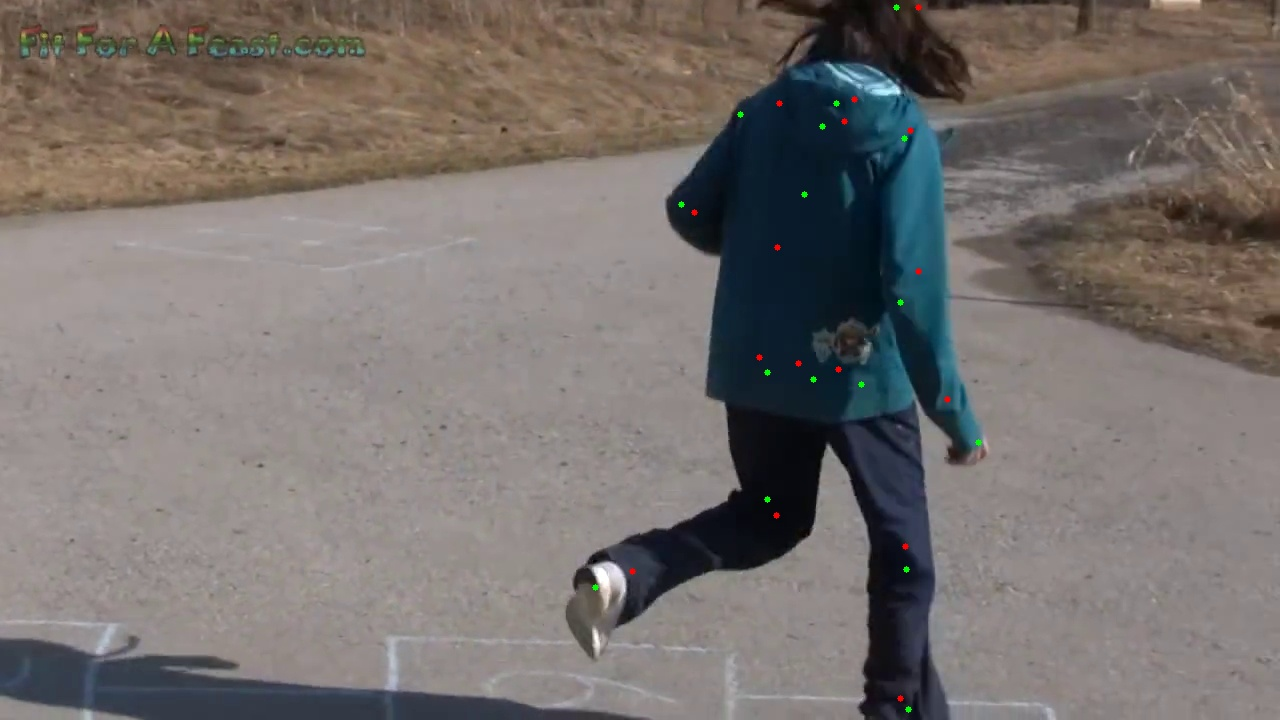

518 008975950.jpg
[[-1.0, -1.0], [968.0, 400.0], [970.0, 385.0], [980.0, 383.0], [980.0, 400.0], [980.0, 410.0], [1188.0, 606.0], [1182.0, 382.0], [961.0, 363.0], [983.0, 336.0], [959.0, 381.0], [961.0, 371.0], [963.0, 365.0], [982.0, 364.0], [986.0, 371.0], [992.0, 381.0]] [[1082.0198974609375, 519.1165161132812], [1044.284912109375, 477.6026306152344], [972.41748046875, 385.8372497558594], [972.1551513671875, 371.92919921875], [1040.8707275390625, 478.8664245605469], [1084.1712646484375, 519.1047973632812], [973.4989013671875, 382.3825378417969], [1113.6715087890625, 395.9494934082031], [1113.6514892578125, 399.4386901855469], [977.8438720703125, 356.0610046386719], [1099.225830078125, 517.417724609375], [1039.35205078125, 473.4875793457031], [1113.4468994140625, 387.8881530761719], [1113.639404296875, 377.5511474609375], [1110.974365234375, 466.2324523925781], [1096.941162109375, 516.7435913085938]]


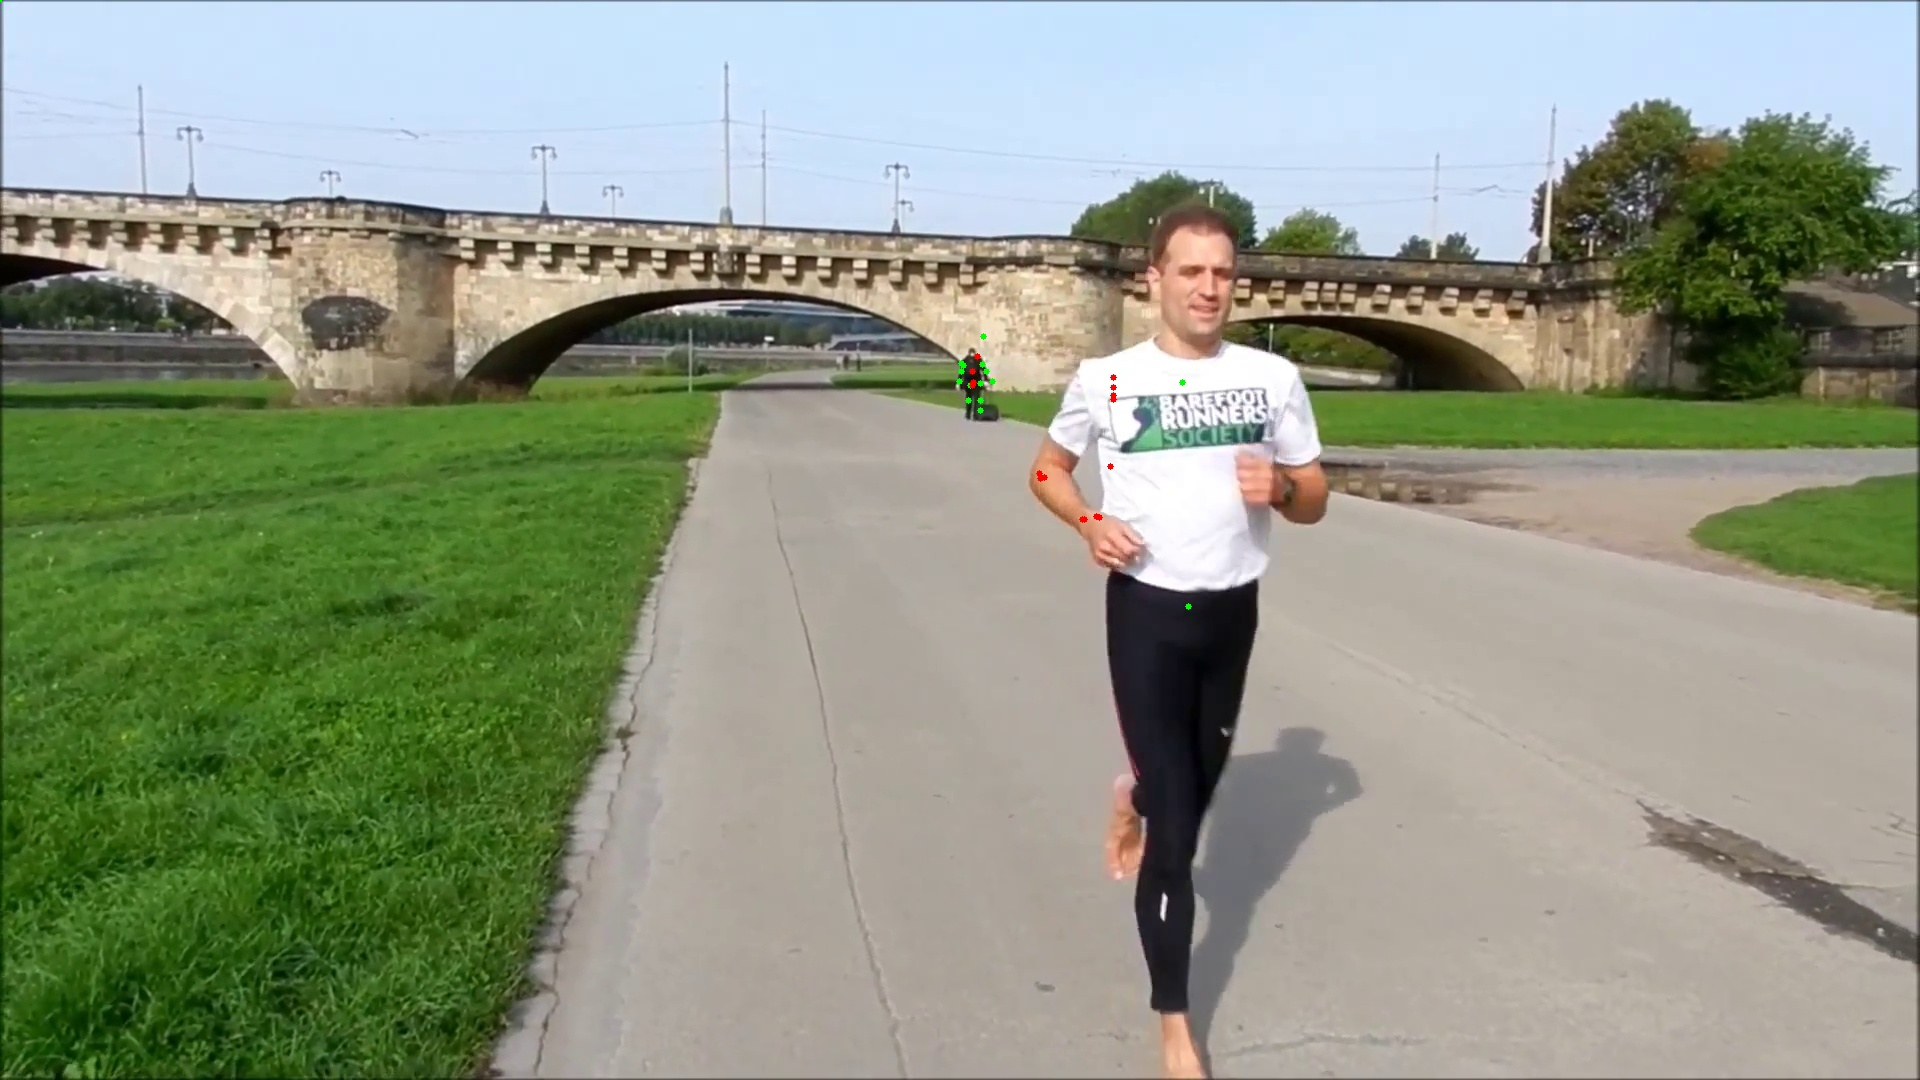

672 064421302.jpg
[[541.0, 215.0], [514.0, 212.0], [468.0, 215.0], [486.0, 237.0], [435.0, 248.0], [389.0, 262.0], [475.0, 264.0], [521.0, 214.0], [522.0, 213.0], [550.0, 192.0], [502.0, 244.0], [499.0, 208.0], [513.0, 198.0], [529.0, 230.0], [533.0, 261.0], [551.0, 268.0]] [[394.07861328125, 260.811279296875], [442.88262939453125, 246.38470458984375], [476.24951171875, 221.00341796875], [481.1561279296875, 228.87258911132812], [447.531494140625, 245.93878173828125], [394.62359619140625, 261.57501220703125], [477.80810546875, 223.26370239257812], [520.7833251953125, 217.20547485351562], [525.212646484375, 213.984375], [550.8303833007812, 192.74749755859375], [546.6851196289062, 267.4776306152344], [529.22802734375, 258.27301025390625], [515.2838134765625, 201.40115356445312], [527.4276733398438, 229.67205810546875], [530.3030395507812, 257.6027526855469], [549.598388671875, 267.5426025390625]]


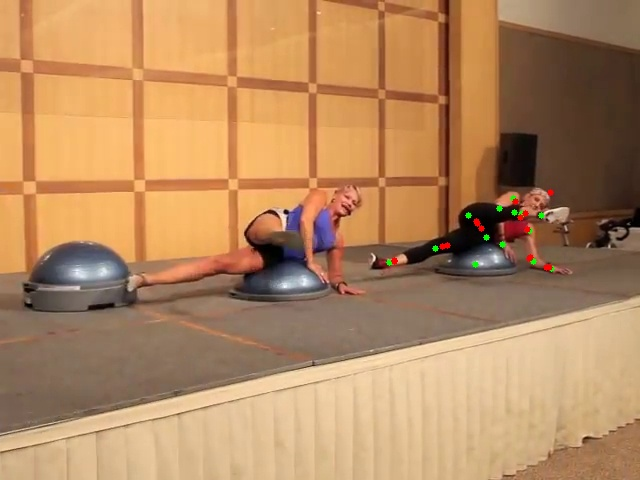

In [17]:

ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_val.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
    annot_pred = json.load(f)

for i, im in outliers_images:
  # Load the image
  print(i, im)
  image = cv2.imread(ROOT_FOLDER + '/data/MPII_COCO/images/' + im)

  # Load annotation keypoints from JSON files

  keypoints1 = annot_truth[i]['joints']
  keypoints2 = annot_pred['annotations'][i]['joints']
  print(keypoints1, keypoints2)
  # Draw keypoints on the image
  for kp in keypoints1:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  for kp in keypoints2:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 0, 255), -1)

  # Resize the image if necessary
  # This step is optional, depending on your images

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'results/image{i}.jpg', image)

  display(Image(filename=f'results/image{i}.jpg'))


Results are in results folder


In [18]:
kps_pred = list()
for i in range(len(annot_truth)):
  
  kp_pred = annot_pred_mpii['annotations'][i]['joints']
  kps_pred.append(kp_pred)
kps_pred = np.array(kps_pred)

mpii_pred_on_mpii_errors = []
# TODO: resolve joint missing
for key in mapping.keys():
    gts = kps_truth[:, key]
    predictions = kps_pred[:, key]
    
    gts = gts[kps_truth_joint_vis[:,key] == 1]
    predictions = predictions[ kps_truth_joint_vis[:,key] == 1 ]

    error = distance(gts, predictions) / box_scale[ kps_truth_joint_vis[:,key] == 1  ]
    mpii_pred_on_mpii_errors.append(error)


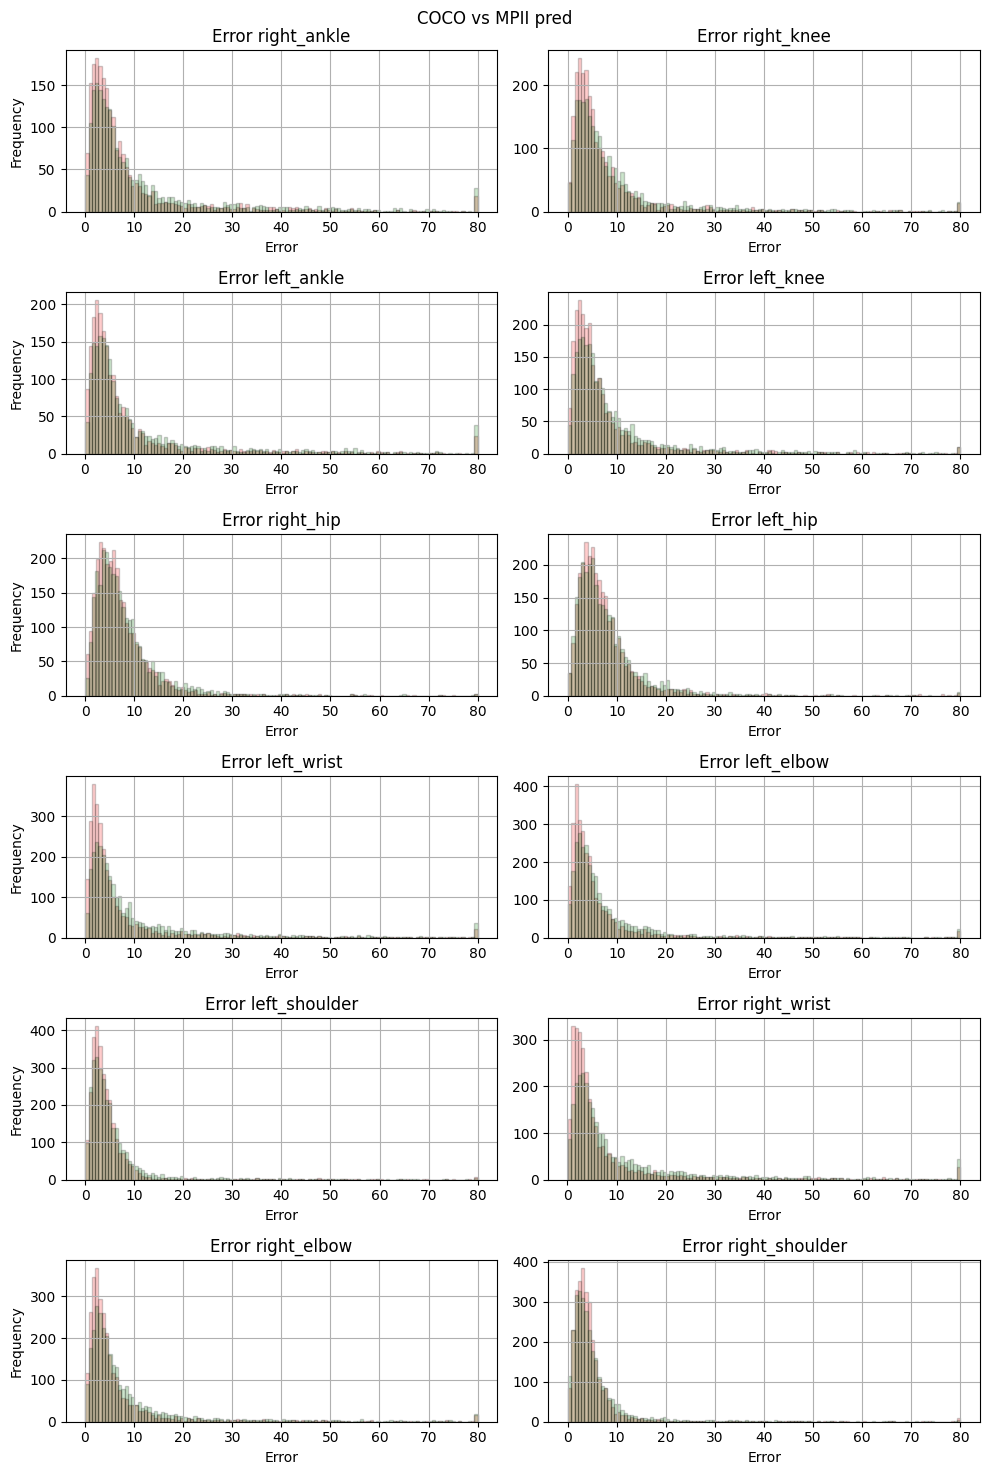

In [19]:
fig, axs = plt.subplots(nrows=(len(mpii_pred_on_mpii_errors)+1)//2, ncols=2, figsize=(10,15))
fig.suptitle("COCO vs MPII pred")
for i in range(len(mpii_pred_on_mpii_errors)):
  row = i // 2
  col = i % 2
  axs[row,col].hist(np.clip(coco_pred_on_mpii_errors[i], 0, 80), bins=120, edgecolor='black', alpha=0.2, color='red')
  axs[row,col].hist(np.clip(mpii_pred_on_mpii_errors[i], 0, 80), bins=120, edgecolor='black', alpha=0.2, color='green')

  axs[row,col].set_title(f'Error {mapping_names[i]}')
  axs[row,col].set_xlabel('Error')
  axs[row,0].set_ylabel('Frequency')
  axs[row,col].grid(True)
plt.tight_layout()
plt.show()

### absolute error between mpii vs coco predictions on mpii dataset

In [20]:
def displayMeanErrors(annot_truth, annot_pred_mpii, annot_pred_coco):
    kps_pred_coco = list()
    kps_pred_mpii = list()
    for i in range(len(annot_truth)):
        kps_pred_mpii.append(annot_pred_mpii['annotations'][i]['joints'])
        kps_pred_coco.append(annot_pred_coco['annotations'][i]['joints'])
    kps_pred_mpii = np.array(kps_pred_mpii)
    kps_pred_coco = np.array(kps_pred_coco)

    print("MPII PRED VS COCO PRED")
    for key in mapping.keys():
        predictions_mpii = kps_pred_mpii[:, key]
        predictions_coco = kps_pred_coco[:, mapping[key]]

        predictions_mpii = predictions_mpii [kps_truth_joint_vis[:,key] == 1]
        predictions_coco = predictions_coco [kps_truth_joint_vis[:,key] == 1]

        error = distance(predictions_mpii, predictions_coco) / box_scale[kps_truth_joint_vis[:,key] == 1]
        print(f'{kps_index2name[key]} has error mean: {np.mean(error)}')

    print("MPII PRED VS MPII GT")
    for key in mapping.keys():
        gts = kps_truth[:, key]
        predictions_mpii = kps_pred_mpii[:, key]

        gts = gts [kps_truth_joint_vis[:,key] == 1]
        predictions_mpii = predictions_mpii [kps_truth_joint_vis[:,key] == 1]

        error = distance(predictions_mpii, gts) / box_scale[ kps_truth_joint_vis[:,key] == 1 ]
        print(f'{kps_index2name[key]} has error mean: {np.mean(error)}')

    print("COCO PRED VS MPII GT")
    for key in mapping.keys():
        gts = kps_truth[:, key]
        predictions_coco = kps_pred_coco[:, mapping[key]]

        gts = gts [kps_truth_joint_vis[:,key] == 1]
        predictions_coco = predictions_coco [kps_truth_joint_vis[:,key] == 1]

        error = distance(predictions_coco, gts) / box_scale [kps_truth_joint_vis[:,key] == 1 ]
        print(f'{kps_index2name[key]} has error mean: {np.mean(error)}')
displayMeanErrors(annot_truth, annot_pred_mpii, annot_pred_coco)

MPII PRED VS COCO PRED
right_ankle has error mean: 11.41155788110999
right_knee has error mean: 9.275721503346189
left_ankle has error mean: 11.172324407655942
left_knee has error mean: 9.059908850838376
right_hip has error mean: 7.2340541669608465
left_hip has error mean: 7.141487709209633
left_wrist has error mean: 10.210975042295209
left_elbow has error mean: 7.6509750295840515
left_shoulder has error mean: 5.17978564930169
right_wrist has error mean: 10.34782332358713
right_elbow has error mean: 7.997949024814717
right_shoulder has error mean: 5.341013866724628
MPII PRED VS MPII GT
right_ankle has error mean: 12.62537299369046
right_knee has error mean: 10.526737026619173
left_ankle has error mean: 12.77060714659583
left_knee has error mean: 10.187787262865864
right_hip has error mean: 8.271872291427186
left_hip has error mean: 8.17557394255949
left_wrist has error mean: 11.52756714869582
left_elbow has error mean: 8.758503243860234
left_shoulder has error mean: 6.0498786903499004


# Using better MPII prediction model

In [21]:
kps_pred = list()
for i in range(len(annot_truth)):
  
  kp_pred = annot_better_pred_mpii['annotations'][i]['joints']
  kps_pred.append(kp_pred)
kps_pred = np.array(kps_pred)

mpii_pred_on_mpii_errors = []
# TODO: resolve joint missing
for key in mapping.keys():
    gts = kps_truth[:, key]
    predictions = kps_pred[:, key]
    
    gts = gts[kps_truth_joint_vis[:,key] == 1]
    predictions = predictions[ kps_truth_joint_vis[:,key] == 1 ]

    error = distance(gts, predictions) / box_scale[ kps_truth_joint_vis[:,key] == 1  ]
    mpii_pred_on_mpii_errors.append(error)


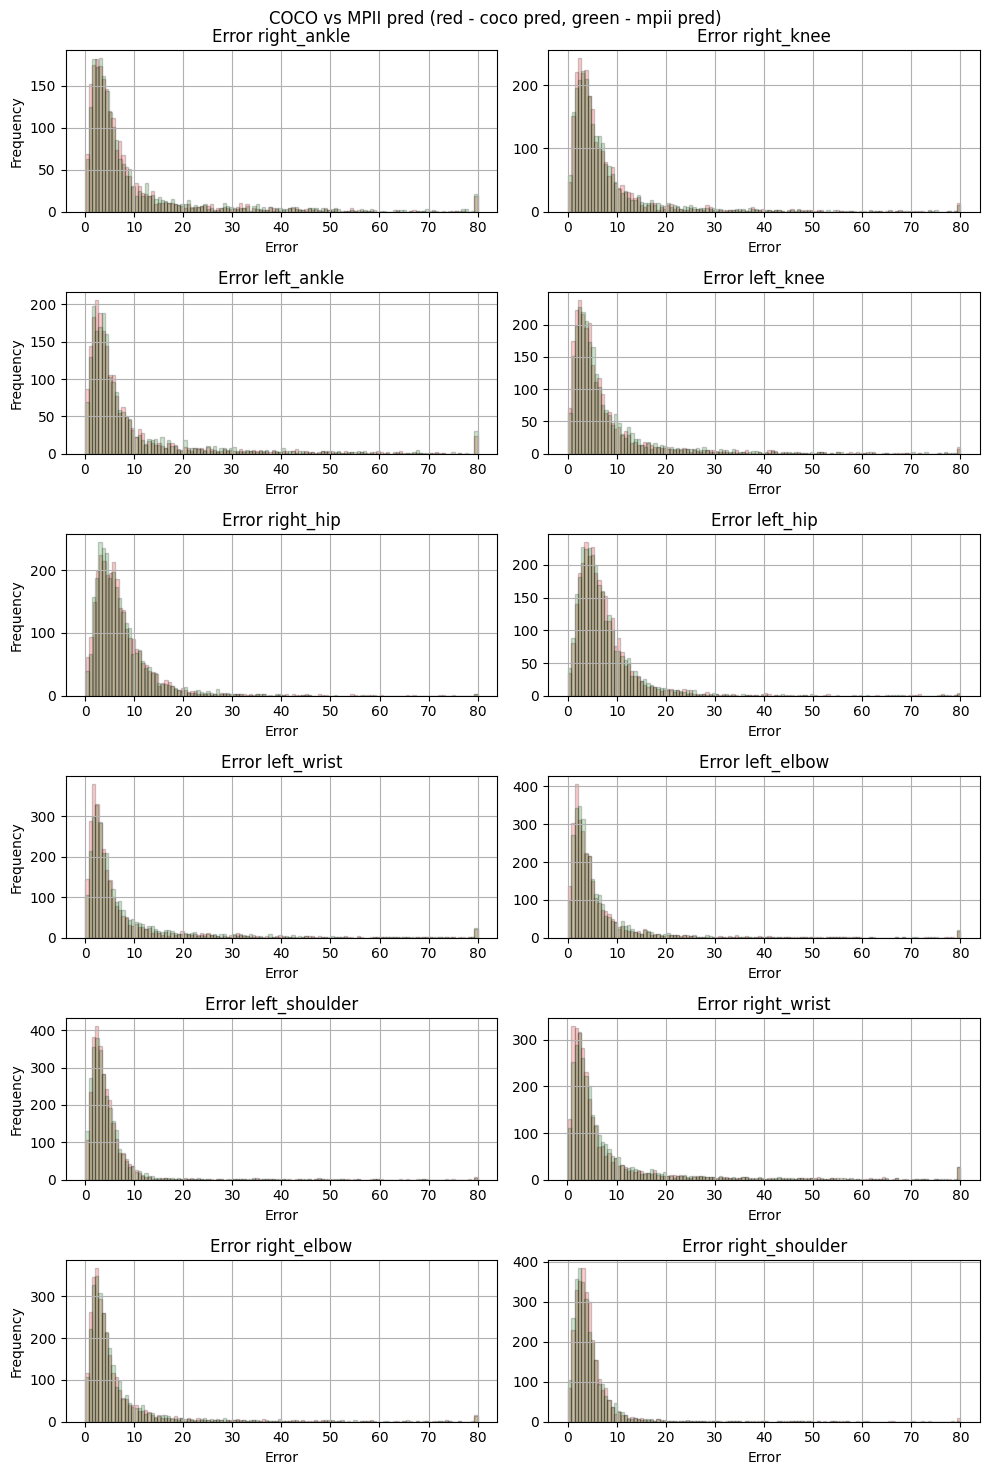

In [22]:
fig, axs = plt.subplots(nrows=(len(mpii_pred_on_mpii_errors)+1)//2, ncols=2, figsize=(10,15))
fig.suptitle("COCO vs MPII pred (red - coco pred, green - mpii pred)")
for i in range(len(mpii_pred_on_mpii_errors)):
  row = i // 2
  col = i % 2
  axs[row,col].hist(np.clip(coco_pred_on_mpii_errors[i], 0, 80), bins=120, edgecolor='black', alpha=0.2, color='red')
  axs[row,col].hist(np.clip(mpii_pred_on_mpii_errors[i], 0, 80), bins=120, edgecolor='black', alpha=0.2, color='green')

  axs[row,col].set_title(f'Error {mapping_names[i]}')
  axs[row,col].set_xlabel('Error')
  axs[row,0].set_ylabel('Frequency')
  axs[row,col].grid(True)
plt.tight_layout()
plt.show()

In [23]:
displayMeanErrors(annot_truth, annot_better_pred_mpii, annot_pred_coco)


MPII PRED VS COCO PRED
right_ankle has error mean: 9.491564258519803
right_knee has error mean: 7.201469429479833
left_ankle has error mean: 9.577525926479336
left_knee has error mean: 7.205060939878932
right_hip has error mean: 6.029924235813146
left_hip has error mean: 6.054399562659326
left_wrist has error mean: 7.885278949491208
left_elbow has error mean: 5.985336733096976
left_shoulder has error mean: 4.422574360048546
right_wrist has error mean: 7.71415259306867
right_elbow has error mean: 5.874964507903717
right_shoulder has error mean: 4.303400222741235
MPII PRED VS MPII GT
right_ankle has error mean: 10.837872408215583
right_knee has error mean: 8.518734681811658
left_ankle has error mean: 10.781200977483111
left_knee has error mean: 8.435142972272386
right_hip has error mean: 7.2366859965390375
left_hip has error mean: 7.411220741744521
left_wrist has error mean: 8.650540305189402
left_elbow has error mean: 6.849178304942251
left_shoulder has error mean: 4.95569924591342
righ

## PckH metrics

### VITPOSE BASE trained on COCO on mergeable points of MPII
- Ankle: 82.238867747287
- Elbow: --
- Hip: 87.46759726692804
- Knee: 85.69359660789596
- Shoulder: 95.55027173913044
- Wrist: --
- PCKh: 87.97138898251133

### RESNET50 trained on MPII
- Ankle: 78.90847973474263
- Elbow: 88.69956376330266
- Head: 96.28240109140519
- Hip: 87.38097823533529
- Knee: 83.49731155293341
- PCKh: 88.22534478272183
- PCKh@0.1: 28.56882628982588
- Shoulder: 95.26154891304348
- Wrist: 83.34765669760513
